In [2]:
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end
from temgymbasic.jax_ray import Ray
from temgymbasic.jax_source import ParallelBeam, PointBeam
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from temgymbasic.jax_utils import calculate_phi_0

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm.auto as tqdm

%matplotlib widget

In [3]:
import sympy as sp

def calculate_object_plane(f, z2):
	return (1/f - 1/z2)**-1


def calculate_image_plane(f, z1):
	return (1/f + 1/z1)**-1


def calculate_focal_length(z1, z2):
	return (1/z1 + 1/z2)**-1

def propagation_matrix(d, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, d], [0, 1]])
	else:
		return xp.array([[1, d], [0, 1]])


def thin_lens_matrix(f, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, 0], [-1/f, 1]])
	else:
		return xp.array([[1, 0], [-1/f, 1]])

def imaging_matrix(M, f, xp=sp):
	if xp == sp:
		return xp.Matrix([[M, 0], [-1/f, 1/M]])
	else:
		return xp.array([[M, 0], [-1/f, 1/M]])
	
def diffraction_matrix(L, f, xp=sp):
	
	obj_prop_mat = propagation_matrix(L, xp)
	lens_mat = thin_lens_matrix(f, xp)
	f_prop_mat = propagation_matrix(f, xp)

	return f_prop_mat @ lens_mat @ obj_prop_mat


(817, 1398, 4)
0.0010204081632653062


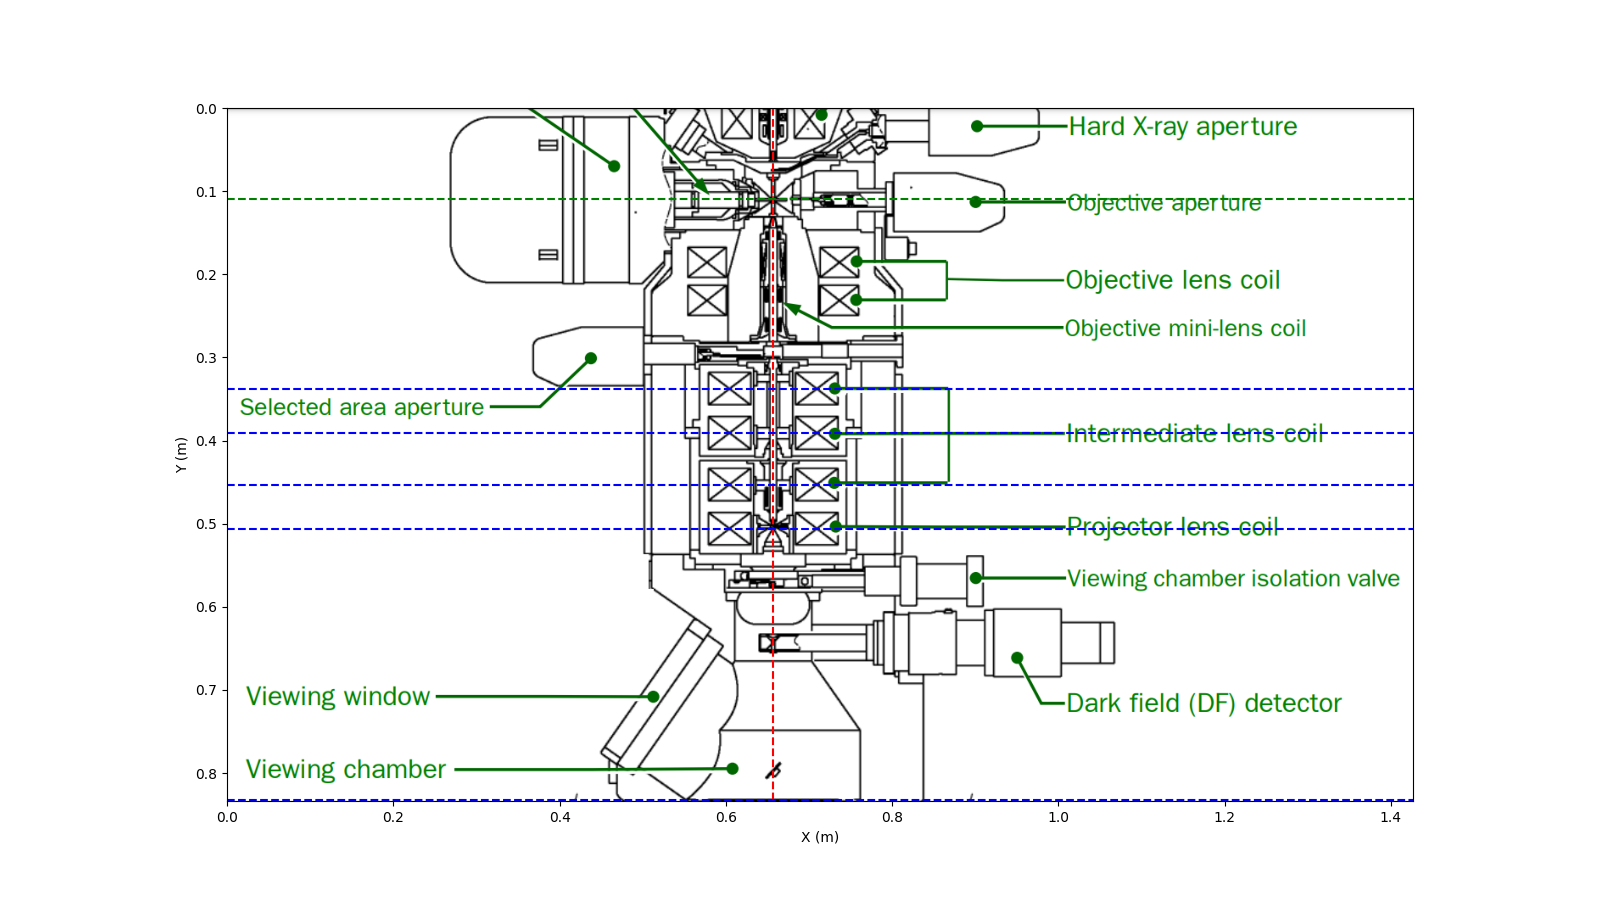

0.19030612244897963


In [4]:
Length_of_Chamber = 0.20 #m
Pixels_of_Chamber = 196 #pixels
scale = Pixel_Size = Length_of_Chamber/Pixels_of_Chamber #m

optical_axis_px = 644 #px
optical_axis_m = optical_axis_px * scale

sample_y_px = 107.5 #px
sample_x_px = optical_axis_px #px

sample_y_m = sample_y_px * scale
sample_x_m = sample_x_px * scale

z_sa_aperture_px = 294.0
z_il1_px = 331.0
z_il2_px = z_il1_px + 52
z_il3_px = z_il2_px + 61
z_pl1_px = z_il3_px + 52
z_det = z_pl1_px + 320

z_sa_aperture_m = z_sa_aperture_px * scale - sample_y_m
z_il1_m = z_il1_px * scale - sample_y_m
z_il2_m = z_il2_px * scale - sample_y_m
z_il3_m = z_il3_px * scale - sample_y_m
z_pl1_m = z_pl1_px * scale - sample_y_m
z_det_m = z_det * scale - sample_y_m

# Load the image
img = mpimg.imread("neoarm.png")
print(img.shape)

# Define scale
print(scale)
height, width = img.shape[:2]
extent = [0, width*scale, height*scale, 0]

# Plot the image
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(img, extent=extent, origin='upper')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.vlines(optical_axis_m, 0, height*scale, color='r', linestyle='--', label='Optical Axis')
ax.hlines(sample_y_m, 0, width*scale, color='g', linestyle='--', label='Sample Y')
ax.hlines(z_il1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl1')
ax.hlines(z_il2_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl2')
ax.hlines(z_il3_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl3')
ax.hlines(z_pl1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl4')
ax.hlines(z_det_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='detector')
plt.show()

print(z_sa_aperture_m)

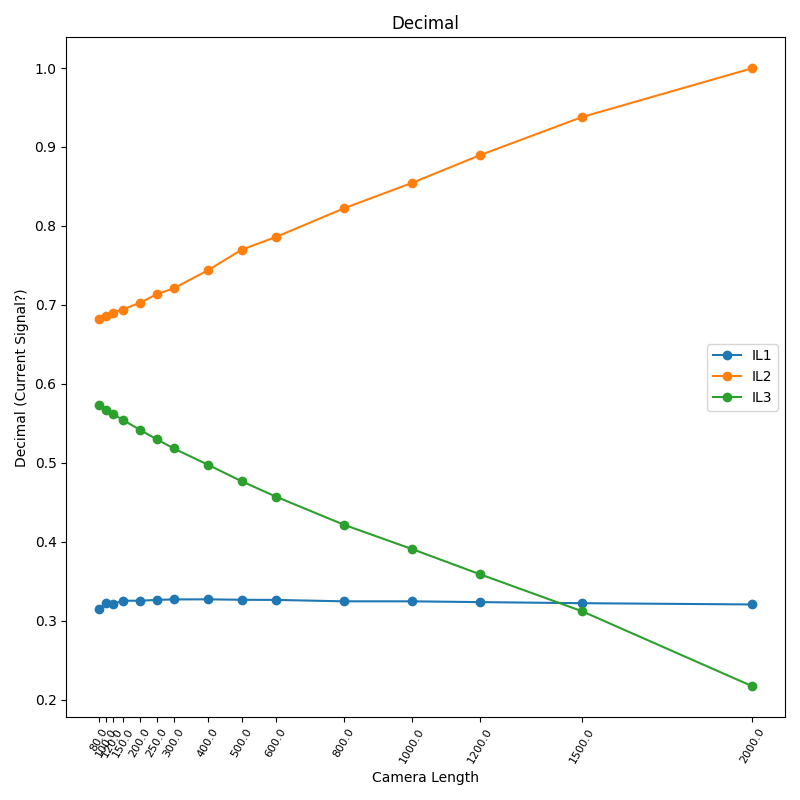

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np


with open(r'results_diff.json') as f:
    data = json.load(f)

lenses = (
 "IL1", 
 "IL2", 
 "IL3",
)

results = {}

for key in data.keys():
    for lens in data[key].keys():
        current = data[key][lens]
        if lens not in results:
            results[lens] = []
        
        camera_length_float = float(key) # convert to meters
        decimal = int(current, 16) / 65535.0
        results[lens].append((camera_length_float, decimal))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_title('Decimal')
ax.set_xlabel('Camera Length')
ax.set_ylabel('Decimal (Current Signal?)')

cameralengths_sorted = sorted([float(k) for k in data.keys()])
# cameralengths_sorted  /= 100

ax.set_xticks(cameralengths_sorted)
ax.set_xticklabels(cameralengths_sorted)
ax.tick_params(axis='x', rotation=60, labelsize=8)

for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    ax.plot(cameralength, decimal, label=lens, marker='o', linestyle='-')

ax.legend(loc='center right')
plt.tight_layout()
plt.show()


$$
\frac{1}{f} \propto {\text{I}^2} \\

\text{decimal} \propto I \\

f \propto \frac{1}{\text{decimal}^2}
$$


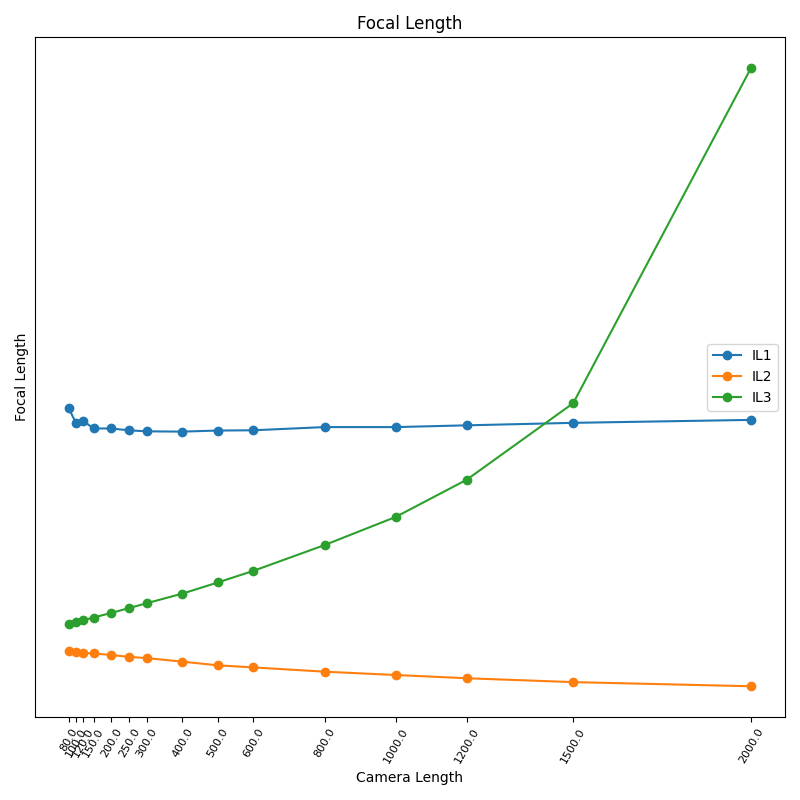

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_title('Focal Length')
ax.set_xlabel('Camera Length')
ax.set_ylabel('Focal Length')

lens_f_dict = {}
cameralengths_sorted = sorted([float(k) for k in data.keys()])
ax.set_xticks(cameralengths_sorted)
ax.set_xticklabels(cameralengths_sorted)
ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_yticks([])
for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    focal_length = 1/(decimal**2)
    ax.plot(cameralength, focal_length, label=lens, marker='o', linestyle='-')
    lens_f_dict[lens] = focal_length
ax.legend(loc='center right')
plt.tight_layout()
plt.show()


In [7]:
from scipy.optimize import curve_fit

lenses = (
 #"IL1", 
 "IL2", 
 "IL3",
)

def model_IL3(x, A, B, C, D, E):
    return (A * jnp.exp(B * x) + C * x ** 2 + D * x + E)

def model_IL1_IL2(x, a, b, c, d):
    return (a / x**2 + b * x **3 + c * x + d)

for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    focal_length = 1/(decimal**2)

    if lens == "IL3":
        popt, pcov = curve_fit(model_IL3, cameralength, focal_length, p0=(1.0, 0.001, 0.01, 0.0001, 0.0001))
        IL3_params = popt
        fitted_focal_length = model_IL3(cameralength, *popt)
    else:
        popt, pcov = curve_fit(model_IL1_IL2, cameralength, focal_length)
        fitted_focal_length = model_IL1_IL2(cameralength, *popt)
        if lens == "IL2":
            IL2_params = popt
        else:
            IL1_params = popt

    # ax.plot(cameralength, fitted_focal_length, label=f'{lens} Fit')
    ax.legend()


In [54]:
def get_eqs_for_f1_f2():

    # Define symbols
    f1, f2, z1, z2, z3, M, C = sp.symbols('f1 f2 z1 z2 z3 M C', real=True)

    # Define propagation and lens matrices with substituted values
    d1 = propagation_matrix(z1, xp=sp)
    l1 = thin_lens_matrix(f1, xp=sp)
    d2 = propagation_matrix(z2, xp=sp)
    l2 = thin_lens_matrix(f2, xp=sp)
    d3 = propagation_matrix(z3, xp=sp)

    # Define lhs and rhs matrices
    lhs = sp.Matrix([[M, 0], [C, 1/M]])
    rhs = d3 * l2 * d2 * l1 * d1

    # Create equations from matrix equality
    mat_eq = sp.Eq(lhs, rhs)

    # Extract individual equations
    mat_eq_00 = sp.Eq(mat_eq.lhs[0, 0], mat_eq.rhs[0, 0])
    mat_eq_01 = sp.Eq(mat_eq.lhs[0, 1], mat_eq.rhs[0, 1])

    #Write mat_eq_01 as an equation for f2
    f2_eq = sp.solve(mat_eq_01, f2)[0].simplify()

    #Substitute the equation for f2 into mat_eq_00
    mat_eq_00 = mat_eq_00.subs(f2, f2_eq)

    #Solve mat_eq_00 for f1
    f1_eq = sp.solve(mat_eq_00, f1)[0].simplify()

    display(sp.Eq(f1, f1_eq), sp.Eq(f2, f2_eq))

    # Make lambda function for f1, solve for all values,
    # then evaluate f2
    f1_lambda = sp.lambdify((M, z1, z2, z3), f1_eq, 'numpy')
    f2_lambda = sp.lambdify((f1, M, z1, z2, z3), f2_eq, 'numpy')

    # return the lambda functions for f1 and f2
    return f1_lambda, f2_lambda

# M_val = -2.5

f1_lambda, f2_lambda = get_eqs_for_f1_f2()


Eq(f1, M*z1*z2/(M*z1 + M*z2 + z3))

Eq(f2, z3*(f1*z1 + f1*z2 - z1*z2)/(f1*z1 + f1*z2 + f1*z3 - z1*z2 - z1*z3))

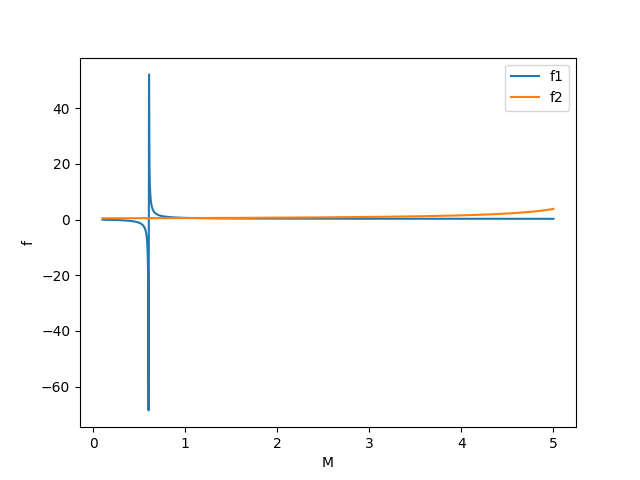

In [71]:
z1 = 0.02
z2 = 0.063
z3 = 0.050

z1_ratio = z1/z2
z3_ratio = z3/z2
z2_ratio = z2/z2

M_vals = np.linspace(-0.1, -5, 1000)
f1 = f1_lambda(M_vals, z1_ratio, z2_ratio, z3_ratio)
f2 = f2_lambda(f1, M_vals, z1_ratio, z2_ratio, z3_ratio)

plt.figure()
plt.plot(-M_vals, f1, label='f1')
plt.plot(-M_vals, f2, label='f2')
plt.xlabel('M')
plt.ylabel('f')
plt.legend()

0.5714285714285713
[[-0.55357143  0.50892857]
 [-1.625      -0.3125    ]]


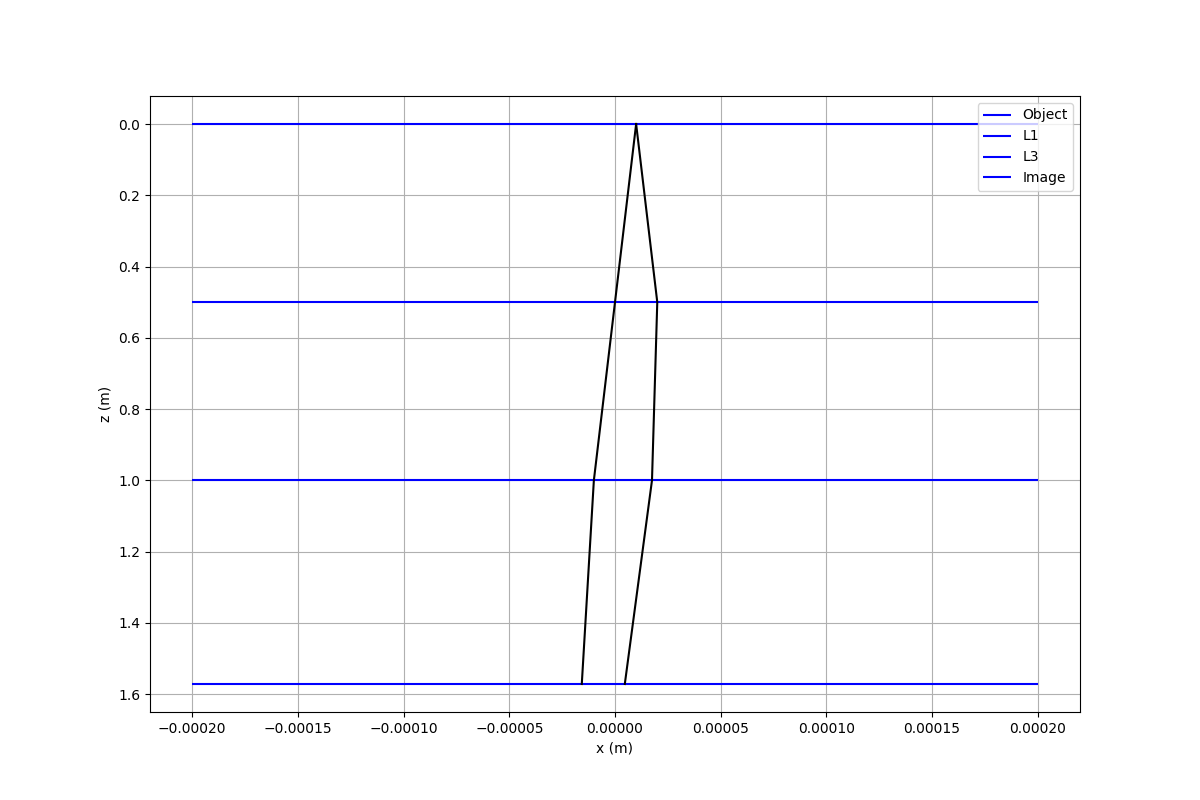

In [201]:
def apply_matrix(rays, matrix):
    return np.array([matrix @ r for r in rays])

x_in = np.array([[0.00001, 0.00002], [0.00001, -0.00002]])

z0 = 0.0
z_l1 = 0.5
z1 = z_l1
f_l1 = 0.8
z_l2 = 1.0
f_l2 = 1
# f_l2 = (z3 * f_l1 * z1) / (f_l1 * z1 - z3 * (f_l1 + z1))
z3 = (f_l1 * f_l2 * z1) / (f_l1 * f_l2 + f_l1 * z1 - f_l2 * z1)
print(z3)


# f_l2 = (z3 * f_l1 * z1) / (f_l1 * z1 - z3 * (f_l1 + z1))

d1 = propagation_matrix(np.abs(z1), xp=np)
l1 = thin_lens_matrix(f_l1, xp=np)
d2 = propagation_matrix(z_l2 - z_l1, xp=np)
l2 = thin_lens_matrix(f_l2, xp=np)
d3 = propagation_matrix(z3, xp=np)

M = d3 @ l2 @ d2 @ l1 @ d1

print(M)

# Store the matrices in a list
matrices = [d1, l1, d2, l2, d3]
z_coords = [z0, z_l1, z_l1, z_l2, z_l2, z_l2 + z3]
rays = x_in
x_coords = [x_in]
# Apply each matrix in sequence and store the results
for matrix in matrices:
    rays = apply_matrix(rays, matrix)
    x_coords.append(rays)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
components = ['Object', 'L1', 'L3', 'Image']
z_positions = [z0, z_l1, z_l2, z_l2 + z3]

for z, component in zip(z_positions, components):
    ax.hlines(z, xmin=-0.0002, xmax=0.0002, colors='b', linestyles='-', label=component)

# Plot the rays
for i in range(len(x_in)):
    ax.plot([x_coords[j][i][0] for j in range(len(x_coords))], z_coords, 'k-')

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.invert_yaxis()
ax.legend()
ax.grid(True)
plt.show()


Plot the rays at each plane. 

In [82]:
def apply_matrix(rays, matrix):
    return jnp.array([matrix @ r for r in rays])

z0 = 0.0
z_obj = 0.00233
f_obj = 0.0023

# Input rays
x_in = np.array([[0.000001, 0.00002], [0.000002, 0.00002]])

# Optical elements
il1_zobj = -(z_il1_m - (z_obj + f_obj))
il1_z_img = 0.03
# M_il1 = -0.23
# il1_f = (il1_zobj * M_il1) / (1 - M_il1)

il2_f = 0.001 #np.abs(il2_zobj)
il3_f = 0.05046

# il1_zimg = calculate_image_plane(il1_zobj, il1_f)
# il2_zobj = -(z_il2_m - (z_il1_m + il1_zimg))

M_pl1 = -100
pl1_z_img = z_det_m - z_pl1_m
pl1_z_obj = M_pl1 * pl1_z_img

# Matrices
d1 = propagation_matrix(z_obj, xp=jnp)
f1 = thin_lens_matrix(f_obj, xp=jnp)
d2 = propagation_matrix(z_il1_m - z_obj, xp=jnp)
f2 = thin_lens_matrix(il1_f, xp=jnp)
d3 = propagation_matrix(z_il2_m - z_il1_m, xp=jnp)
f3 = thin_lens_matrix(il2_f, xp=jnp)
d4 = propagation_matrix(z_il3_m - z_il2_m, xp=jnp)
f4 = thin_lens_matrix(il3_f, xp=jnp)
d5 = propagation_matrix(il3_f, xp=jnp)
d6 = propagation_matrix(jnp.abs(pl1_zobj), xp=jnp)
f5 = thin_lens_matrix(pl1_f, xp=jnp)
d7 = propagation_matrix(z_det_m - z_pl1_m, xp=jnp)

camera_length_objective = 2.0

def forward(il2_f):
    il3_f = 0.050
    f3 = thin_lens_matrix(il2_f, xp=jnp)
    f4 = thin_lens_matrix(il3_f, xp=jnp)
    return d7 @ f5 @ d6 @ f4 @ d5 @ f3 @ d4 @ f2 @ d3 @ f1 @ d2 @ f1 @ d1

def loss(il2_f):
    out_mat = forward(il2_f)
    A, B, C, _ = out_mat[0, 0], out_mat[0, 1], out_mat[1, 0], out_mat[1, 1]
    loss = A ** 2 + (B + camera_length_objective) ** 2 + (C - 1/camera_length_objective) ** 2
    return loss

# from scipy.optimize import minimize

# init_guess = [il2_f, il3_f]
# out = minimize(loss, init_guess, method='Nelder-Mead')


# mat = forward(*[0.071044356, 0.086])

# print(mat[0, 1])
# print(mat[0, 0])

In [89]:
import jax

import jax.numpy as jnp

# Vectorize the loss function
vectorized_loss = jax.vmap(lambda il2_f: loss(il2_f))

# JIT compile the vectorized loss function
compiled_loss = jax.jit(vectorized_loss)

shape = 1000000
il2_fs = jnp.linspace(0.071038, 0.071042, shape)
# il3_fs = jnp.linspace(0.001, 0.2, shape)

# IL2_FS, Il3_FS = jnp.meshgrid(il2_fs, il3_fs)

# Prepare the parameters as a 2D array
# params = jnp.stack([il2_fs, 0.01], axis=-1)

# Compute losses
losses = compiled_loss(il2_fs)



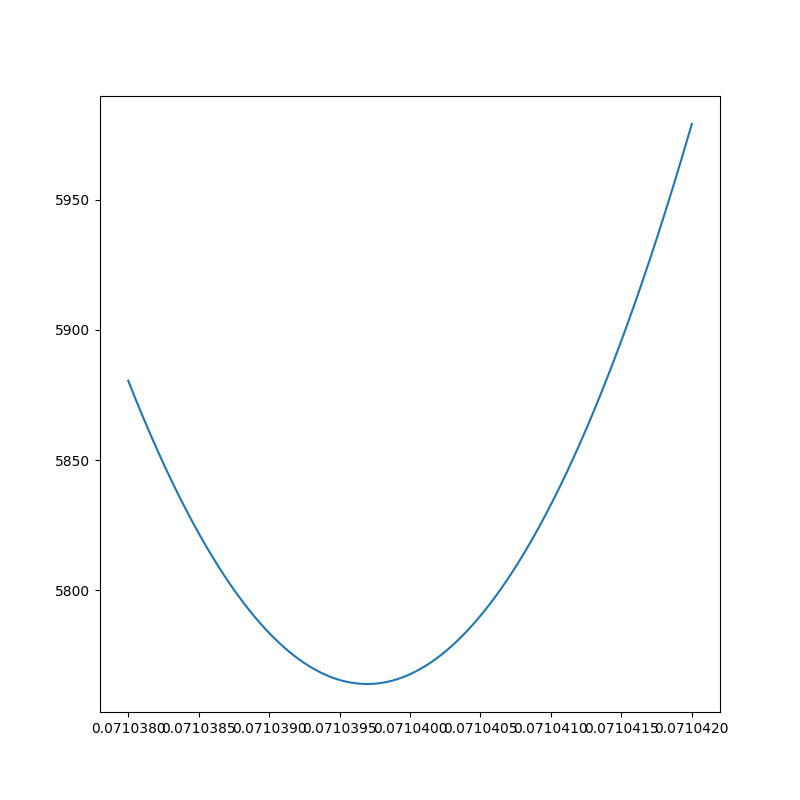

In [90]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(il2_fs, losses)
# plt.imshow(losses, norm=LogNorm(), extent=(il2_fs.min(), il2_fs.max(), il3_fs.min(), il3_fs.max()), origin='lower')
# plt.axis('auto')
# plt.colorbar()

In [ ]:

# Composite matrices
IL1_image_plane_matrix = d3 @ f2 @ d2 @ f1 @ d1
IL3_focal_plane_matrix = d6 @ f4 @ d5 @ f3 @ d4 @ IL1_image_plane_matrix
M_il2_il3 = (d6 @ f4 @ d5 @ f3 @)[0, 0]
det_image_plane_matrix = d7 @ f5 @ d7 @ IL3_focal_plane_matrix

print(IL1_image_plane_matrix)
print(IL3_focal_plane_matrix)
print(det_image_plane_matrix)
print("Intermediate Lens 1 Magnification:", M_il1)
print("Intermidiate Lens 2 & 3 Magnification:", M_il2_il3)
print("Projector Lens Magnification:", M_pl1)
print("Camera Length cm: MP * M3&2 * M1 * f_obj", (M_pl1 * M_il2_il3 * M_il1 * f_obj)*100)

# Ray tracing through each stage
x_coords = [x_in]
z_coords = [z0]

# Store the matrices in a list
matrices = [d1, f1, d2, f2, d3, d4, f3, d5, f4, d6, d7, f5, d8]

rays = x_in

# Apply each matrix in sequence and store the results
for matrix in matrices:
    rays = apply_matrix(rays, matrix)
    x_coords.append(rays)
    z_coords.append(z_coords[-1] + matrix[0, 1])

# Final rays after all matrices
x_out = rays

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
components = ['Objective', 'IL1', 'IL2', 'IL3', 'PL1', 'Detector']
z_positions = [z_obj, z_il1_m, z_il2_m, z_il3_m, z_pl1_m, z_det_m]

for z, component in zip(z_positions, components):
    ax.hlines(z, xmin=-0.0002, xmax=0.0002, colors='b', linestyles='-', label=component)

# Image planes
image_planes = [z_il1_m + il1_zimg, z_il3_m + il3_f, z_pl1_m + pl1_zimg]
for idx, img_z in enumerate(image_planes):
    ax.hlines(img_z, xmin=-0.0002, xmax=0.0002,
              colors='orange', linestyles='--', label=f'Image Plane {idx+1}')

# Plot the rays
for i in range(len(x_in)):
    ax.plot([x_coords[j][i][0] for j in range(len(x_coords))], z_coords, 'k-')

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.invert_yaxis()
ax.legend()
ax.grid(True)
plt.show()

print(il1_f, il2_f, il3_f, pl1_f)

In [9]:
import optax

camera_lengths = jnp.array(sorted([float(key) for key in data.keys()])) # convert from centimetres to metres. 
#camera_lengths = camera_lengths / 100

optimizer = optax.adam(1e-2)

run_function = run_to_end
run_function_grad = jax.jacobian(run_to_end)

def create_model(i11_f, il2_f, il3_f, pl1_f):
    return [
        comp.Lens(z=z_obj, focal_length=f_obj),
        comp.Lens(z=z_il1_m, focal_length=i11_f),
        comp.Lens(z=z_il2_m, focal_length=il2_f),
        comp.Lens(z=z_il3_m, focal_length=il3_f),
        comp.Lens(z=z_pl1_m, focal_length=pl1_f),
        comp.Detector(z=z_det_m, pixel_size=0.01, shape=(100, 100))
    ]

def create_ray(num_models):
    return PointBeam(z=0.0, n_rays=num_models, semi_angle=0.0, tilt_yx=(0, 1e-5), voltage=jnp.ones(num_models))

# Batch parameters
start_index = 4
num_models = 7
camera_length_batch = jnp.array(camera_lengths[start_index:start_index+num_models])

# a, b, c, d = jnp.ones(4) * 1e-3

# # camera_length_batch
# IL1_f_batch = a * model_IL1_IL2(camera_length_batch, *IL1_params)
# IL2_f_batch = b * model_IL1_IL2(camera_length_batch, *IL2_params)
# IL3_f_batch = c * model_IL3(camera_length_batch, *IL3_params)
# pl1_f_batch = d * jnp.ones(num_models)

# # Vectorize model creation
# models = jax.vmap(create_model)(IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch)

# # Create a single ray for each model
# ray_batch = create_ray(num_models)

# # Vectorize the run functions
# ray_out = jax.vmap(run_function, in_axes=(0, 0))(ray_batch, models)
# ray_grad_out = jax.vmap(run_function_grad, in_axes=(0, 0))(ray_batch, models)

# ABCD = ray_grad_out.matrix.squeeze()
# print(ABCD.shape)
# A = ABCD[0, 0]
# B = ABCD[0, 2]
# C = ABCD[2, 0]
# D = ABCD[2, 2]

# print(A, B, C, D)

In [10]:
# @jax.jit
def forward_pass(p):
    a, b, c, d = p

    IL1_f_batch = a * model_IL1_IL2(camera_length_batch, *IL1_params)
    IL2_f_batch = b * model_IL1_IL2(camera_length_batch, *IL2_params)
    IL3_f_batch = c * model_IL3(camera_length_batch, *IL3_params)
    pl1_f_batch = d * jnp.ones(num_models)

    models = jax.vmap(create_model)(IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch)

    ray_grad_out = jax.vmap(run_function_grad, in_axes=(0, 0))(rays, models)
    ABCD = ray_grad_out.matrix.squeeze()

    return ABCD, IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch

# @jax.jit
def loss_fn(p):
    ABCD, IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch = forward_pass(p)
    
    A = ABCD[:, 0, 0]
    B = ABCD[:, 0, 2]
    C = ABCD[:, 2, 0]

    # per_model_loss = (
    #     (A) ** 2
    #     + (B + camera_length_batch) ** 2
    #     + (C - 1.0 / camera_length_batch) ** 2
    # )
    mean_A = jnp.mean(A ** 2)
    mean_B = jnp.mean((B + camera_length_batch) ** 2) 
    mean_C = jnp.mean((C - 1.0 / camera_length_batch) ** 2)

    loss = mean_A + mean_B + mean_C

    # penalty_il1_f = jnp.mean(jnp.square(jnp.maximum(0.0, 0.01 - p[0]))) + jnp.mean(jnp.square(jnp.maximum(0.0, p[0] - 0.05)))
    
    # pl1_object_planes = calculate_object_plane(-pl1_f_batch, z_det_m)
    # pl1_object_planes_dist_to_IL3 = jnp.abs(pl1_object_planes - z_il3_m)
    
    # penalty_focal_IL3 = jnp.mean(jnp.square(IL3_f_batch - pl1_object_planes_dist_to_IL3))
    
    # penalty_pl1_f = jnp.sum(jnp.square(jnp.maximum(0.0, pl1_f_batch - 0.01)))
    
    # scale_penalties = 1e6
    
    # loss += scale_penalties * (penalty_il1_f + penalty_focal_IL3 + penalty_pl1_f)

    #Make this a differentiable function - parabolic or exponential - relu. 
    # negative_penalty = jnp.sum(jnp.square(jnp.minimum(0.0, p)))
    # scale_negative_penalty = 1e8
    # loss += scale_negative_penalty * negative_penalty

    return float(loss)



In [11]:
import scipy

In [20]:
rays = create_ray(num_models)
init_guess = jnp.array([1e-2, 1e-2, 1e-2, 1e-2])

loss_fn(init_guess)


375664167.01189345

In [21]:
scipy.optimize.minimize(loss_fn, init_guess, method='Nelder-Mead', options={'disp': True, "maxiter": 10})

C:\Users\dl277493\AppData\Local\Temp\ipykernel_30968\2002065543.py:1: RuntimeWarning: Maximum number of iterations has been exceeded.
  scipy.optimize.minimize(loss_fn, init_guess, method='Nelder-Mead', options={'disp': True, "maxiter": 10})


       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 26436044.17944443
             x: [ 9.878e-03  1.247e-02  5.936e-03  1.282e-02]
           nit: 10
          nfev: 18
 final_simplex: (array([[ 9.878e-03,  1.247e-02,  5.936e-03,  1.282e-02],
                       [ 1.028e-02,  1.278e-02,  5.894e-03,  1.207e-02],
                       ...,
                       [ 1.012e-02,  1.165e-02,  7.047e-03,  1.121e-02],
                       [ 1.061e-02,  1.126e-02,  7.305e-03,  1.142e-02]]), array([ 2.644e+07,  2.807e+07,  3.086e+07,  8.445e+07,
                        1.040e+08]))

In [13]:
raise

RuntimeError: No active exception to reraise

  0%|          | 0/10000 [00:00<?, ?it/s]

[57.67986931 37.0586141  25.85694758 14.71893344  9.56363104  6.76322581
  3.97874507]
[2.73820975 1.77189193 1.24697353 0.72502654 0.48342782 0.35217896
 0.22165369]
[0.12862033 0.12868158 0.12874286 0.12886547 0.12898816 0.12911093
 0.1293567 ]
0.10524387567934783
[44.32272142 28.47680913 19.86915536 11.31041374  7.34894443  5.19703975
  3.05737186]
[1.64003304 1.06126323 0.74686674 0.43424996 0.28954597 0.21093531
 0.13275805]
[0.15564093 0.15571506 0.15578921 0.15593758 0.15608604 0.1562346
 0.15653201]
0.11511592772794312
[30.9364373  19.87628448 13.86830184  7.89445897  5.12942688  3.62743733
  2.13398884]
[0.55257942 0.35757342 0.25164321 0.14631266 0.09755727 0.07107083
 0.04473042]
[0.18096548 0.18105167 0.18113788 0.18131039 0.18148301 0.18165575
 0.18200154]
0.12463142482366123
[17.58783006 11.29996678  7.88433825  4.4881187   2.91615636  2.0622527
  1.21320476]
[-0.35921421 -0.23244705 -0.16358521 -0.09511318 -0.06341886 -0.04620088
 -0.02907781]
[0.20385156 0.20394865 0.20

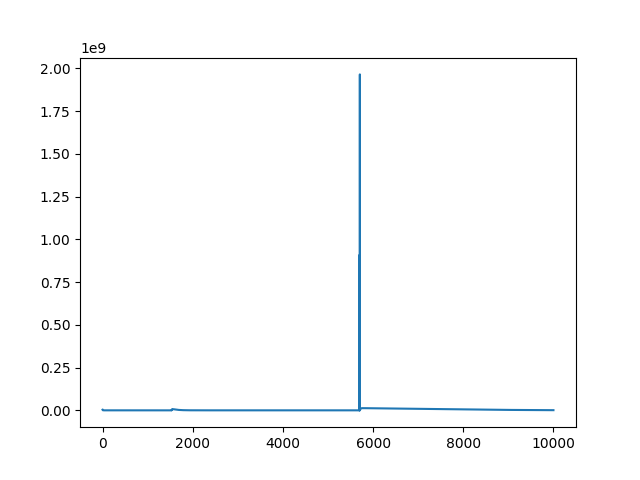

In [ ]:
key = jax.random.PRNGKey(0)
#Better initial guess.
a, b, c, d = jax.random.uniform(key, shape=(4,), minval=0, maxval=0.01)

init_guess = jnp.array([a, b, c, d])
opt_state = optimizer.init(init_guess)
params = init_guess

rays = create_ray(num_models)

loss_val_list =[]
n_steps = 10000

for step in tqdm.trange(n_steps):
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_val_list.append(loss_val)

    print(params[0] * model_IL1_IL2(camera_length_batch, *IL1_params))
    print(params[1] * model_IL1_IL2(camera_length_batch, *IL2_params))
    print(params[2] * model_IL3(camera_length_batch, *IL3_params))
    print(params[3])

plt.figure()
plt.plot(loss_val_list)

print(params)



In [1]:
plt.figure()
plt.plot(loss_val_list)

NameError: name 'plt' is not defined

In [11]:
# il2_f = params[1] + params[2] * jnp.abs(camera_length)
# il3_f = params[3] - params[4] * jnp.abs(camera_length)

# model = [
#     comp.Lens(z=0.00233, focal_length=f_obj),
#     comp.Lens(z=z_il1_m, focal_length=params[0]),
#     comp.Lens(z=z_il2_m, focal_length=il2_f),
#     comp.Lens(z=z_il3_m, focal_length=il3_f),
#     comp.Lens(z=z_pl1_m, focal_length=pl1_f),
#     comp.Detector(z=z_det_m, pixel_size=0.01, shape=(100, 100)),
# ]

# ro = run_to_end(ray, model)
# print(ro)
# dro_dri = jax.jacobian(run_to_end, argnums=0)(ray, model)
# ABCD = dro_dri.matrix.squeeze()
# A = ABCD[0, 0]
# B = ABCD[0, 2]
# C = ABCD[2, 0]
# D = ABCD[2, 2]
# print(A, B, C)
# print(camera_length)